In [2]:
!pip install nmrglue

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 3.7 MB/s eta 0:00:00


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 132
         Function evaluations: 246


/usr/local/lib/python3.10/dist-packages/nmrglue/analysis/peakpick.py:386: ComplexWarning: Casting complex values to real discards the imaginary part
  scale.append(float(sc))
/usr/local/lib/python3.10/dist-packages/nmrglue/fileio/table.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  new_rec[name] = col.astype(format)
<ipython-input-111-a1d08afd2425>:62: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  area = simps(np.real(spectrum[left:right]), frequencies[left:right])
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


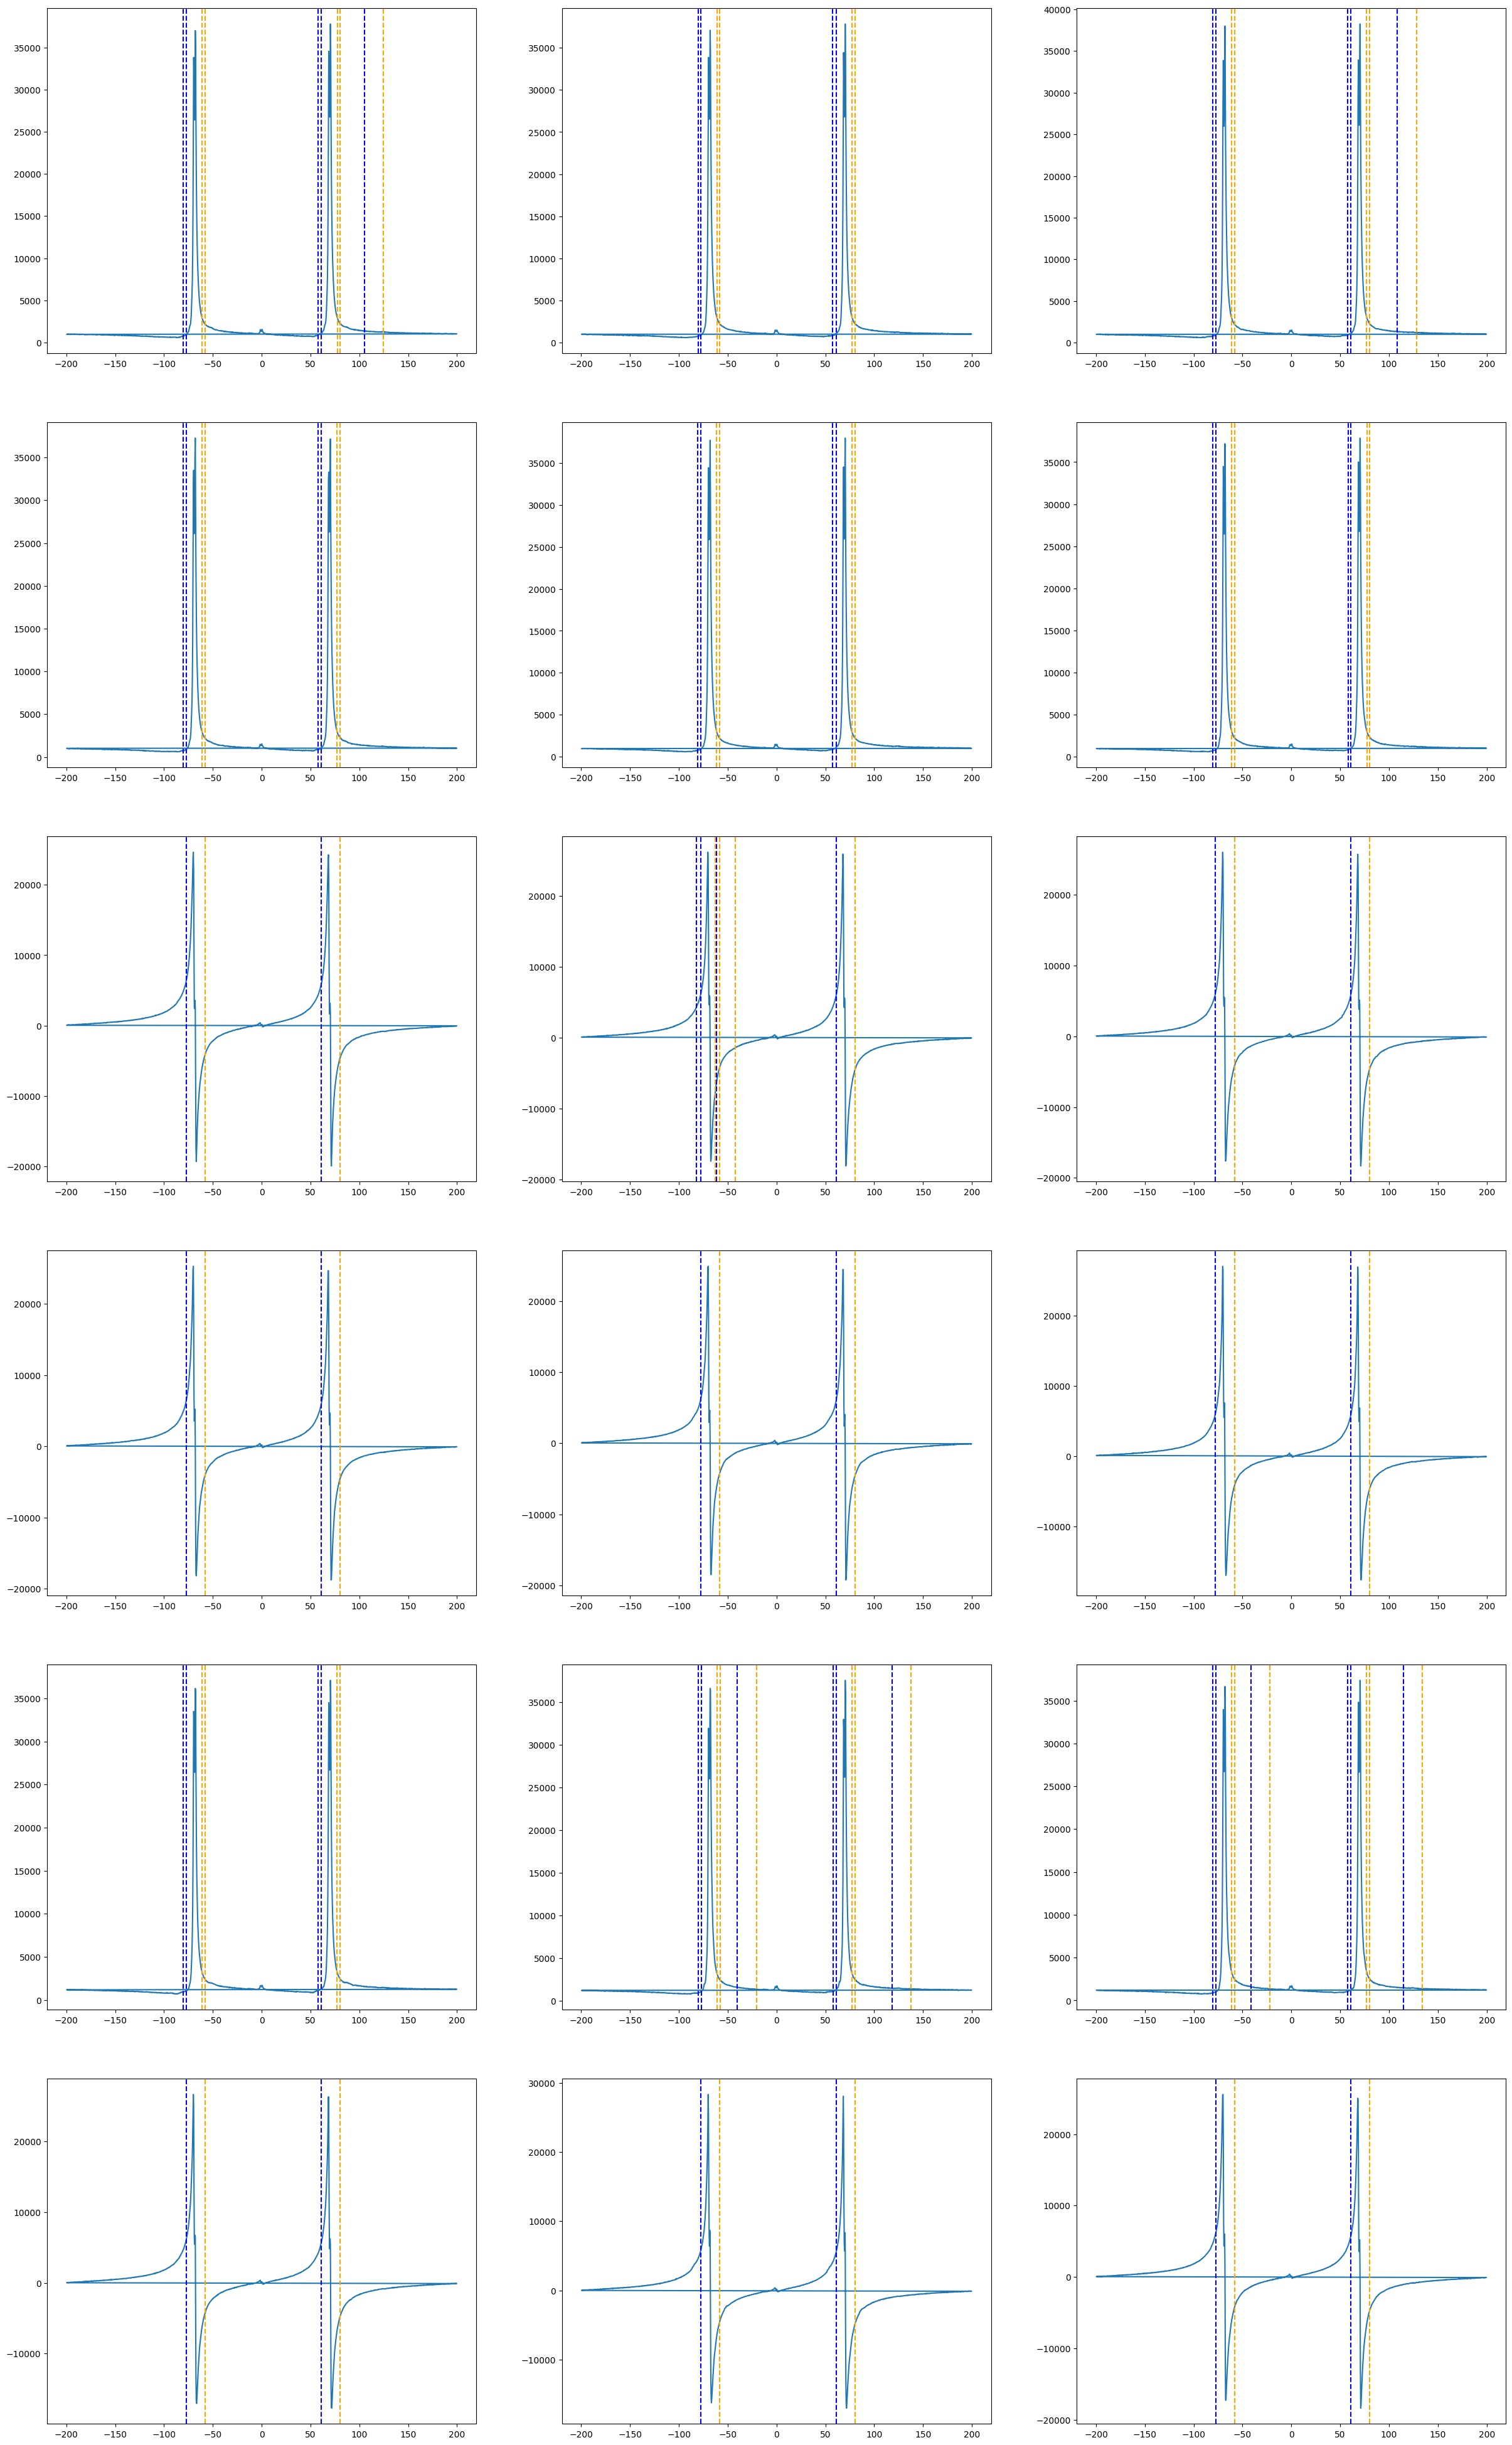

In [111]:
from scipy.integrate import simps
import pathlib as pth
import numpy as np
import nmrglue as ng
from matplotlib import pyplot as plt
import pandas as pd


def proper_phases(data):
    spectrum_unpr = np.fft.fft(data[0])
    spectrum, phases = ng.proc_autophase.autops(spectrum_unpr, 'acme', return_phases=True)
    return phases

def identity_operator_idx(data):
    max_vals = []
    for i in range(len(data)):
        spectrum_unpr = np.fft.fft(data[i])
        maxima = max(np.real(spectrum_unpr))
        max_vals.append(maxima)
    threshold = np.mean(maxima) / 100
    indices = [i for i, value in enumerate(max_vals) if value < threshold]
    return indices

tn = 'H' # Название исследуемого ядра

dic, data = ng.varian.read(r'test')
df = pd.read_csv('dict.csv')
filtered_df = df[df['nucleus'] == tn]
at = float(dic['procpar']['at']['values'][0])
peak_width = filtered_df['peak_width'].values[0]
center = filtered_df['center'].values[0]
region = filtered_df['borders'].values[0]

phases = proper_phases(data)
id_idx = identity_operator_idx(data)
n = len(data[0])
time = np.linspace(0, at, n)
dt = at / n

frequencies = np.fft.fftfreq(n, d=dt)
dnu = frequencies[1] - frequencies[0]
peak_idx_width = int(peak_width / dnu)
mask = (frequencies >= center-region) & (frequencies <= center+region)
frequencies = frequencies[mask]

integrated_areas = []
fig, axs = plt.subplots(6, 3, figsize=(30, 50))
axs = axs.flatten()
spectras = []
peaks = []

for idx in range(len(data)):
    if idx not in id_idx and idx != 0:
        spectrum = np.fft.fft(data[idx])[mask]
        corrected_spectrum = spectrum * np.exp(1j * 2 * np.pi / 360 * (phases[0]))
        normalized_spectrum = spectrum / max(spectrum)
        loc_peaks = ng.analysis.peakpick.pick(normalized_spectrum, 0.07, -0.07, table=True)
        iter = 1
        for peak in loc_peaks:
            left = int(peak[0] - peak_idx_width)
            right = int(peak[0] + peak_idx_width)
            area = simps(np.real(spectrum[left:right]), frequencies[left:right])
            integrated_areas.append([{'index':idx + 1}, {'integral_num': iter}, {'area':area}])
            iter += 1
        peaks.append(loc_peaks)
        spectras.append(corrected_spectrum)
for idx in range(len(spectras)):
    axs[idx].plot(frequencies, spectras[idx])
    for i in range(len(peaks[idx])):
        s = int(peaks[idx][i][0] + peak_idx_width)
        p = int(peaks[idx][i][0] - peak_idx_width)
        axs[idx].axvline(x=frequencies[s], color='orange', linestyle='--')
        axs[idx].axvline(x=frequencies[p], color='blue', linestyle='--')
plt.show()

In [112]:
integrated_areas

[[{'index': 8}, {'integral_num': 1}, {'area': -62782.57244771518}],
 [{'index': 8}, {'integral_num': 2}, {'area': 12106.997361288591}],
 [{'index': 8}, {'integral_num': 3}, {'area': -70843.73086194675}],
 [{'index': 8}, {'integral_num': 4}, {'area': -92108.14999066608}],
 [{'index': 8}, {'integral_num': 5}, {'area': -99918.48231079806}],
 [{'index': 9}, {'integral_num': 1}, {'area': -63179.28282194483}],
 [{'index': 9}, {'integral_num': 2}, {'area': -71310.05321838029}],
 [{'index': 9}, {'integral_num': 3}, {'area': -95600.78566440524}],
 [{'index': 9}, {'integral_num': 4}, {'area': -100289.88165260018}],
 [{'index': 10}, {'integral_num': 1}, {'area': -61792.75230682702}],
 [{'index': 10}, {'integral_num': 2}, {'area': 10198.569484684884}],
 [{'index': 10}, {'integral_num': 3}, {'area': -70024.81748244258}],
 [{'index': 10}, {'integral_num': 4}, {'area': -94195.44376971525}],
 [{'index': 10}, {'integral_num': 5}, {'area': -102184.54370512368}],
 [{'index': 11}, {'integral_num': 1}, {'a

In [113]:
peaks

[rec.array([(212., 2, 8.05435093,  30.58299572),
            (344., 3, 1.        ,   0.14110084),
            (996., 4, 8.59716305,  26.11188255),
            (203., 1, 3.32737234,  -8.43467888),
            (987., 4, 1.78771994, -10.01689008)],
           dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')]),
 rec.array([(212., 2, 8.09148169,  31.20532915),
            (996., 4, 8.20882287,  26.46196441),
            (202., 1, 6.88055324,  -8.51038448),
            (987., 3, 3.43253787, -10.0874186 )],
           dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')]),
 rec.array([(212., 1, 8.77731308,  32.8096592 ),
            (355., 2, 0.        ,   0.07014226),
            (996., 3, 8.80842589,  27.50703245),
            (202., 1, 7.21719226,  -9.09006406),
            (986., 3, 7.82074133, -10.86045888)],
           dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')]),
 rec.array([(211., 1, 9.01251222, 29.11340122),